In [ ]:
# default_exp datasets.bases.graph

# Graph dataset
> Base class for graph datasets.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from typing import List, Optional, Callable, Union, Any, Tuple

import numpy as np
import importlib

import torch
import networkx as nx
import matplotlib.pyplot as plt

import torch_geometric
from torch_geometric.utils import to_networkx

from recohut.utils.plots import GraphNetworkPlot

In [ ]:
#export
class GraphDataset():
    def __init__(self, data, shuffle=False, graph=None):
        inputs = data[0]
        inputs, mask, len_max = self.data_masks(inputs, [0])
        self.inputs = np.asarray(inputs)
        self.mask = np.asarray(mask)
        self.len_max = len_max
        self.targets = np.asarray(data[1])
        self.length = len(inputs)
        self.shuffle = shuffle
        self.graph = graph

    def generate_batch(self, batch_size):
        if self.shuffle:
            shuffled_arg = np.arange(self.length)
            np.random.shuffle(shuffled_arg)
            self.inputs = self.inputs[shuffled_arg]
            self.mask = self.mask[shuffled_arg]
            self.targets = self.targets[shuffled_arg]
        n_batch = int(self.length / batch_size)
        if self.length % batch_size != 0:
            n_batch += 1
        slices = np.split(np.arange(n_batch * batch_size), n_batch)
        slices[-1] = slices[-1][:(self.length - batch_size * (n_batch - 1))]
        return slices

    def get_slice(self, i):
        inputs, mask, targets = self.inputs[i], self.mask[i], self.targets[i]
        items, n_node, A, alias_inputs = [], [], [], []
        for u_input in inputs:
            n_node.append(len(np.unique(u_input)))
        max_n_node = np.max(n_node)
        for u_input in inputs:
            node = np.unique(u_input)
            items.append(node.tolist() + (max_n_node - len(node)) * [0])
            u_A = np.zeros((max_n_node, max_n_node))
            for i in np.arange(len(u_input) - 1):
                if u_input[i + 1] == 0:
                    break
                u = np.where(node == u_input[i])[0][0]
                v = np.where(node == u_input[i + 1])[0][0]
                u_A[u][v] = 1
            u_sum_in = np.sum(u_A, 0)
            u_sum_in[np.where(u_sum_in == 0)] = 1
            u_A_in = np.divide(u_A, u_sum_in)
            u_sum_out = np.sum(u_A, 1)
            u_sum_out[np.where(u_sum_out == 0)] = 1
            u_A_out = np.divide(u_A.transpose(), u_sum_out)
            u_A = np.concatenate([u_A_in, u_A_out]).transpose()
            A.append(u_A)
            alias_inputs.append([np.where(node == i)[0][0] for i in u_input])
        return alias_inputs, A, items, mask, targets

    @staticmethod
    def data_masks(all_usr_pois, item_tail):
        us_lens = [len(upois) for upois in all_usr_pois]
        len_max = max(us_lens)
        us_pois = [upois + item_tail * (len_max - le) for upois, le in zip(all_usr_pois, us_lens)]
        us_msks = [[1] * le + [0] * (len_max - le) for le in us_lens]
        return us_pois, us_msks, len_max

Example

In [ ]:
train_data = ([[1, 2, 3], [2, 3, 4], [1, 2, 4], [2, 3], [1]], 
              [4, 5, 5, 4, 2])

tds = GraphDataset(train_data, shuffle=False)
print(tds.generate_batch(1))
print(tds.generate_batch(2))
print(tds.inputs)

tds = GraphDataset(train_data, shuffle=True)
print(tds.generate_batch(1))
print(tds.generate_batch(2))
print(tds.inputs)

[array([0]), array([1]), array([2]), array([3]), array([4])]
[array([0, 1]), array([2, 3]), array([4])]
[[1 2 3]
 [2 3 4]
 [1 2 4]
 [2 3 0]
 [1 0 0]]
[array([0]), array([1]), array([2]), array([3]), array([4])]
[array([0, 1]), array([2, 3]), array([4])]
[[1 2 4]
 [1 2 3]
 [2 3 4]
 [2 3 0]
 [1 0 0]]


## PyGDataset

In [ ]:
#export
class PyGDataset:
    """For PyTorch-Geometric Datasets"""
    def __init__(self):
        pass

    def load(self, data_id, **kwargs):
        module = importlib.import_module('torch_geometric.datasets')
        class_ = getattr(module, data_id)
        self.dataset = class_(**kwargs)

    def info(self):
        dataset = self.dataset
        print(f'Dataset: {dataset}:')
        print('======================')
        print(f'Number of graphs: {len(dataset)}')
        print(f'Number of features: {dataset.num_features}')
        print(f'Number of classes: {dataset.num_classes}')

        print('')
        data = self.dataset[0]
        print(data)
        print('==============================================================')

        # Gather some statistics about the graph.
        print(f'Number of nodes: {data.num_nodes}')
        print(f'Number of edges: {data.num_edges}')
        print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
        if 'train_mask' in data:
            print(f'Number of training nodes: {data.train_mask.sum()}')
            print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
        print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
        print(f'Contains self-loops: {data.contains_self_loops()}')
        print(f'Is undirected: {data.is_undirected()}')

    def plot(self, **kwargs):
        data = self.dataset[0]
        G = to_networkx(data, to_undirected=True)
        _ = GraphNetworkPlot(G, color=data.y, **kwargs)

Example

In [ ]:
ds = PyGDataset()
ds.load('KarateClub')
ds.info()

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


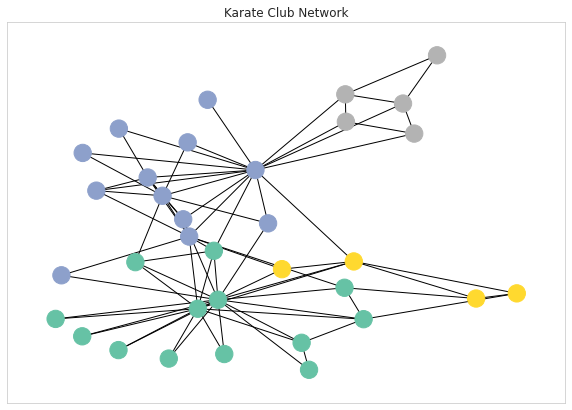

In [ ]:
kwargs = {'title': 'Karate Club Network', 'figsize':(10,7)}

ds.plot(**kwargs)

In [ ]:
ds = PyGDataset()

kwargs = {'root':'.', 'name':'USA'}
ds.load(data_id='Airports', **kwargs)
ds.info()

Dataset: UsaAirports():
Number of graphs: 1
Number of features: 1190
Number of classes: 4

Data(x=[1190, 1190], edge_index=[2, 13599], y=[1190])
Number of nodes: 1190
Number of edges: 13599
Average node degree: 11.43
Contains isolated nodes: True
Contains self-loops: False
Is undirected: False


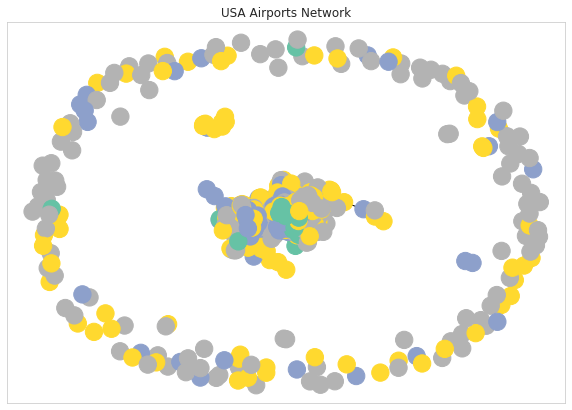

In [ ]:
kwargs = {'title': 'USA Airports Network', 'figsize':(10,7)}

ds.plot(**kwargs)